In [1]:
# 모듈 수정 시 따로 커널 재시작 안해도 바로 적용해주는 extension.
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 0
%env DETECTRON2_DATASETS ./data/
%cd /surrogate_v2/

env: CUDA_VISIBLE_DEVICES=0
env: DETECTRON2_DATASETS=./data/
/surrogate_v2


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from pathlib import Path
from typing import Sequence

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
import models
import codec_ops
import checkpoint

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Image Visualization

In [16]:
task = 'detection'
od_network_name = 'faster_rcnn_X_101_32x8d_FPN_3x'
saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_post_only/s50000_bs2_adam_lr0.0001_exponential_0.1')
step = 50000

od_cfg = utils.get_od_cfg(task, od_network_name)
end2end = models.EndToEndNetwork(6, task, 'cn', od_cfg)
ckpt = checkpoint.Checkpoint(saved_filter_model_path)
ckpt.load(end2end.filter, step=step)

end2end.eval()
end2end.cuda();

In [17]:
sample_img_path = 'data/open-images-v6-etri/validation/0b30ad1afeba9bca.jpg'
img_arr = cv2.imread(sample_img_path)

codec = 'vvenc'
codec_quality = 47
downscale = 0

out = end2end(img_arr, codec, codec_quality, downscale, eval_filtering=True)

In [19]:
out['image'].keys()

dict_keys(['reconstructed', 'post_filtered'])

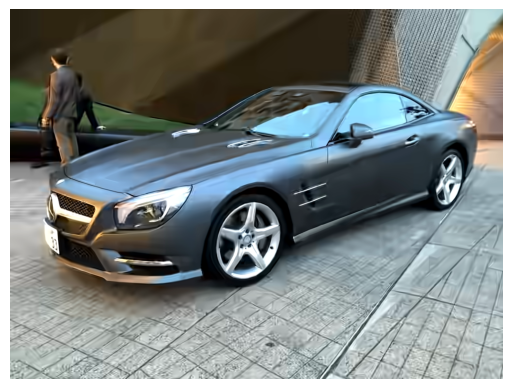

In [23]:
plt.imshow(out['image']['reconstructed'])
plt.axis(False)
plt.show()

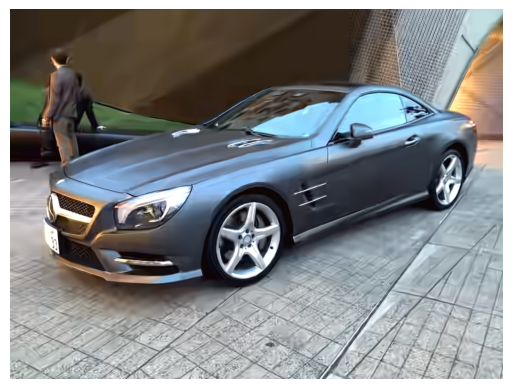

In [24]:
plt.imshow(out['image']['post_filtered'])
plt.axis(False)
plt.show()

## Result Plotting

In [7]:
codec = 'vvenc'

saved_filter_model_path1 = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.5/s100000_bs2_adam_lr0.0001_constant/')
saved_filter_model_path2 = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld0.5/s100000_bs2_adam_lr0.0001_constant/')

base_result = pd.read_csv('result_baseline.csv')
filter_result1 = pd.read_csv(saved_filter_model_path1 / 'result.csv')
filter_result2 = pd.read_csv(saved_filter_model_path2 / 'result.csv')

base_result = base_result[base_result['codec'] == codec]
filter_result1 = filter_result1[filter_result1['codec'] == codec]
filter_result1 = filter_result1[filter_result1['step'] == 50000]
filter_result2 = filter_result2[filter_result2['codec'] == codec]


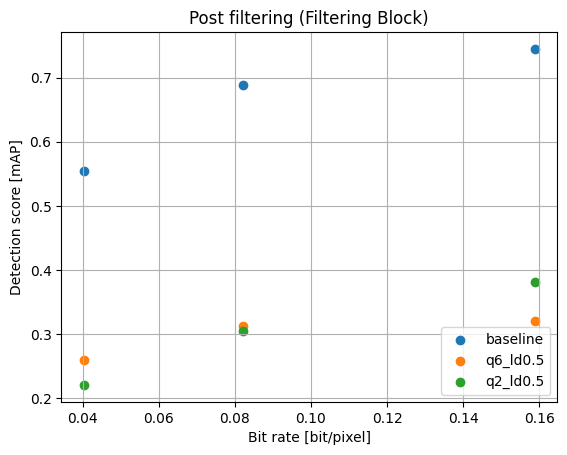

In [8]:
plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
plt.scatter(x=filter_result1['bpp'], y=filter_result1['metric'], label=saved_filter_model_path1.parent.name)
plt.scatter(x=filter_result2['bpp'], y=filter_result2['metric'], label=saved_filter_model_path2.parent.name)
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')
plt.title('Post filtering (Filtering Block)')
plt.savefig('result.png', dpi=300)
plt.show()